🚗 CAR DAMAGE DETECTION SYSTEM (FOCUSED ON CAR ONLY) 🚗
Upload a clear image of the damaged car:


Saving damg.jpg to damg (19).jpg
Uploaded: damg (19).jpg


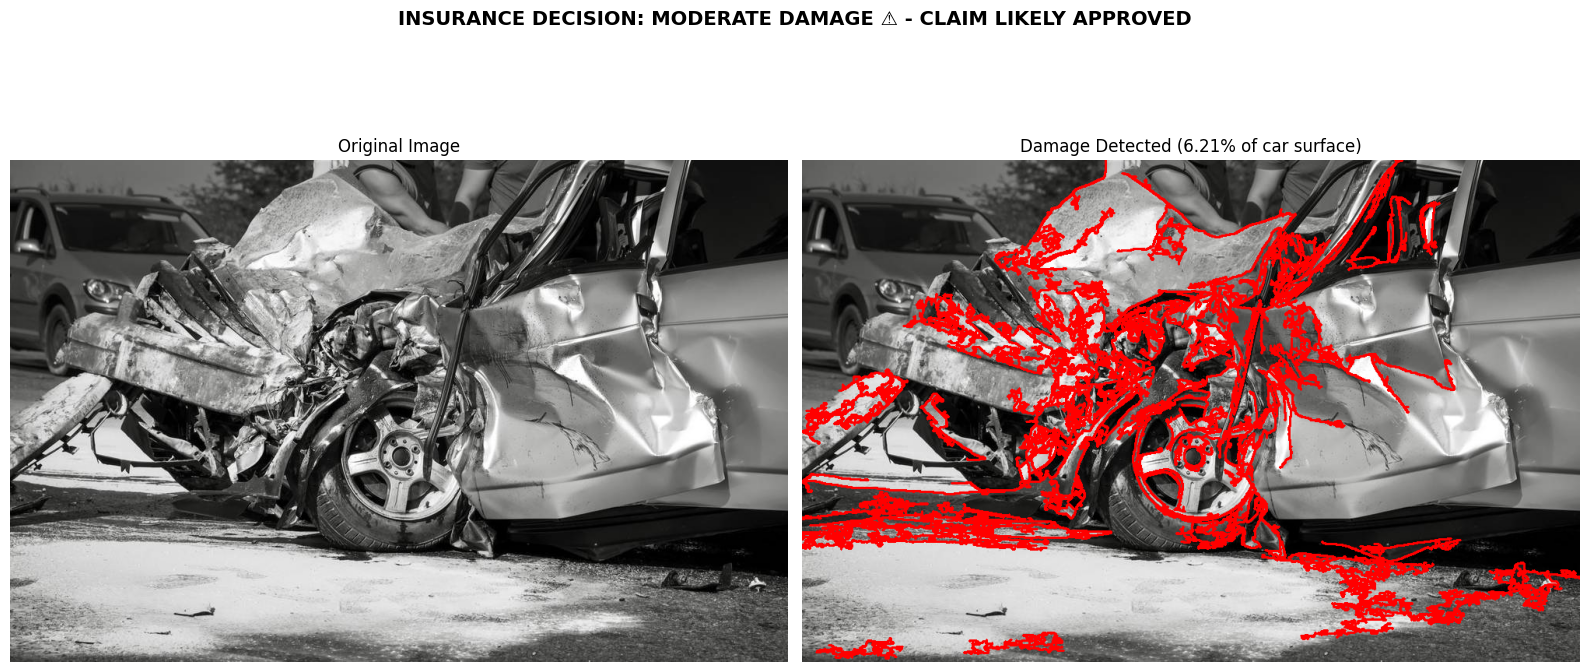


=== FINAL ASSESSMENT ===
Damaged area: 6.21% of car surface
MODERATE DAMAGE ⚠️ - CLAIM LIKELY APPROVED


In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from google.colab import files
import matplotlib.pyplot as plt

def upload_image():
    """Upload an image file from local machine"""
    uploaded = files.upload()
    for filename in uploaded.keys():
        print(f"Uploaded: {filename}")
        img = cv2.imdecode(np.frombuffer(uploaded[filename], np.uint8), cv2.IMREAD_COLOR)
        return img
    return None

def segment_car(img):
    """Segment the car from the background using color and edge detection"""
    # Convert to HSV for better color segmentation
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Define color ranges for common car colors (adjust if needed)
    lower_white = np.array([0, 0, 200], dtype=np.uint8)
    upper_white = np.array([180, 30, 255], dtype=np.uint8)
    lower_black = np.array([0, 0, 0], dtype=np.uint8)
    upper_black = np.array([180, 255, 50], dtype=np.uint8)
    lower_silver = np.array([0, 0, 100], dtype=np.uint8)
    upper_silver = np.array([180, 30, 200], dtype=np.uint8)

    # Threshold for white, black, and silver cars
    mask_white = cv2.inRange(hsv, lower_white, upper_white)
    mask_black = cv2.inRange(hsv, lower_black, upper_black)
    mask_silver = cv2.inRange(hsv, lower_silver, upper_silver)

    # Combine masks (white, black, silver)
    car_mask = cv2.bitwise_or(mask_white, mask_black)
    car_mask = cv2.bitwise_or(car_mask, mask_silver)

    # Apply morphological operations to clean the mask
    kernel = np.ones((5,5), np.uint8)
    car_mask = cv2.morphologyEx(car_mask, cv2.MORPH_CLOSE, kernel)
    car_mask = cv2.morphologyEx(car_mask, cv2.MORPH_OPEN, kernel)

    # Find the largest contour (assumed to be the car)
    contours, _ = cv2.findContours(car_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None

    largest_contour = max(contours, key=cv2.contourArea)
    car_mask = np.zeros_like(car_mask)
    cv2.drawContours(car_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

    # Apply mask to original image
    segmented_car = cv2.bitwise_and(img, img, mask=car_mask)

    return segmented_car, car_mask

def detect_damage(segmented_car, car_mask):
    """Detect damage ONLY on the car's surface"""
    # Convert to grayscale
    gray = cv2.cvtColor(segmented_car, cv2.COLOR_BGR2GRAY)

    # Apply CLAHE for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)

    # Edge detection (Canny works better for dents)
    edges = cv2.Canny(enhanced, 50, 150)

    # Apply mask to ensure we only detect edges on the car
    edges = cv2.bitwise_and(edges, edges, mask=car_mask)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours (only irregular shapes = damage)
    min_area = 500  # Minimum damage area
    damage_contours = []

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < min_area:
            continue

        # Check for irregularity (damage is not a smooth shape)
        hull = cv2.convexHull(cnt)
        hull_area = cv2.contourArea(hull)
        if hull_area == 0:
            continue

        solidity = float(area) / hull_area
        if solidity < 0.8:  # Less solid = more likely damage
            damage_contours.append(cnt)

    return damage_contours

def assess_damage(img, car_mask, damage_contours):
    """Calculate damage severity & draw results"""
    car_area = cv2.countNonZero(car_mask)
    if car_area == 0:
        return 0.0, img.copy()

    total_damage_area = sum(cv2.contourArea(cnt) for cnt in damage_contours)
    damage_percentage = (total_damage_area / car_area) * 100

    # Draw damage areas
    output = img.copy()
    for cnt in damage_contours:
        cv2.drawContours(output, [cnt], -1, (0, 0, 255), 2)

    return damage_percentage, output

def insurance_decision(damage_percentage):
    """Decision based on damage percentage"""
    if damage_percentage > 10:
        return "SEVERE DAMAGE 🚨 - CLAIM APPROVED"
    elif damage_percentage > 5:
        return "MODERATE DAMAGE ⚠️ - CLAIM LIKELY APPROVED"
    elif damage_percentage > 2:
        return "MINOR DAMAGE ℹ️ - CLAIM MAY BE APPROVED"
    else:
        return "NO SIGNIFICANT DAMAGE ✅ - CLAIM REJECTED"

def display_results(original, processed, damage_percentage, decision):
    """Display results side-by-side"""
    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(processed, cv2.COLOR_BGR2RGB))
    plt.title(f"Damage Detected ({damage_percentage:.2f}% of car surface)")
    plt.axis('off')

    plt.suptitle(f"INSURANCE DECISION: {decision}", fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()

def main():
    print("🚗 CAR DAMAGE DETECTION SYSTEM (FOCUSED ON CAR ONLY) 🚗")
    print("Upload a clear image of the damaged car:")

    # Step 1: Upload image
    img = upload_image()
    if img is None:
        print("❌ No image uploaded!")
        return

    # Step 2: Segment the car (ignore environment)
    segmented_car, car_mask = segment_car(img)
    if segmented_car is None:
        print("❌ Failed to detect car in the image!")
        return

    # Step 3: Detect damage ONLY on the car
    damage_contours = detect_damage(segmented_car, car_mask)

    # Step 4: Assess damage severity
    damage_percentage, processed_img = assess_damage(img, car_mask, damage_contours)

    # Step 5: Insurance decision
    decision = insurance_decision(damage_percentage)

    # Step 6: Display results
    display_results(img, processed_img, damage_percentage, decision)

    print("\n=== FINAL ASSESSMENT ===")
    print(f"Damaged area: {damage_percentage:.2f}% of car surface")
    print(decision)

if __name__ == "__main__":
    main()